In [1]:
from pyomo.environ import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use({'figure.facecolor':'white'})

In [2]:
def data_viz(model, d_i):
    Pdt = pd.DataFrame()
    price = pd.DataFrame()
    energy = pd.DataFrame()
    Pdmt = pd.DataFrame()
    Pdmt_max = pd.DataFrame()
    util = pd.DataFrame()
    # 12 is the number of blocks
    blocks_m = ['d'+str(i+1) for i in range(12)]

    for t in model.TIME:
        for a in model.AGG:
            if a == d_i:
                Pdt.loc[t,'Consumption'] = model.Pdt[a,t].value
        price.loc[t, 'Price'] = model.ct[t].value
        for m in blocks_m:
                for a,m_u,t_u in model.UTILS:
                    if a == d_i and t_u == t and m_u == m:
                        Pdmt.loc[t,m] = model.Pdmt[a,m,t].value
                        Pdmt_max.loc[t,m] = model.PblockMax[a,m,t].value
                        util.loc[t,m] = model.util[a,m,t].value
    for a in model.AGG:
        if a == d_i:
            energy.loc[a, 'Energy'] = model.Einflex[a]

    energy_tot = np.cumsum(Pdt)

    fig, ax = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(12,8))
    ax[0,0].plot(Pdt.index, energy_tot, linestyle='--', marker='o', alpha=0.6, label='$E_{cum}$');
    ax[0,0].fill_between(Pdt.index, energy_tot['Consumption'], np.zeros(len(energy_tot)), alpha=0.6)
    ax[0,0].plot(Pdt.index, Pdt, marker='o', label='$P_{'+str(d_i)+',t}$');ax[0,0].set_xlabel('Time [h]');ax[0,0].set_ylabel('Active Power [kW]');ax[0,0].set_title('Agg '+str(d_i)+' Consumption');
    ax[0,0].hlines(energy['Energy'], Pdt.index[0], Pdt.index[-1], colors='red', label='$E_{min}$')
    ax[0,0].legend(bbox_to_anchor=(0.1,0.7), loc='center', borderaxespad=0)
    ax[0,1].plot(price.index, price, marker='o');ax[0,1].set_xlabel('Time [h]');ax[0,1].set_ylabel('Price [$]');ax[0,1].set_title('Price');
    util.plot(ax=ax[1,0], kind='bar', alpha=1, rot=0, edgecolor='white', linewidth=1);ax[1,0].set_xlabel('Time [h]');ax[1,0].set_ylabel('Utility [$/kWh]');ax[1,0].set_title('Utility Blocks');
    Pdmt_max.plot(ax=ax[1,1], kind='bar', alpha=1, rot=0, edgecolor='white', linewidth=1, legend=None);ax[1,1].set_xlabel('Time [h]');ax[1,1].set_ylabel('Active Power [kW]');ax[1,1].set_title('Flexibility');
    Pdmt.plot(ax=ax[1,1], kind='bar', alpha=1, rot=0, edgecolor='black', linewidth=1, hatch='/');
    fig.tight_layout()
    fig.show;
    plt.savefig('aggregator_'+str(d_i)+'.png', bbox_inches='tight')

In [3]:
def read_input(filename):
    AggData = pd.read_excel(filename, sheet_name='AggData')
    DemandBlocks = pd.read_excel(filename, sheet_name='DemandBlocks')
    TimeData = pd.read_excel(filename, sheet_name='TimeData')

    return {'AggData':AggData, 'DemandBlocks':DemandBlocks, 'TimeData':TimeData}

In [4]:
data = read_input(r'Input_Files\Aggregator.xlsx')
for i in data.keys():
    print(i, ':\n', data[i])
    print('\n')

AggData :
   AGG   RU   RD
0  a1  100 -100
1  a2  100 -100
2  a3  100 -100


DemandBlocks :
      DB  Load  MargUtil AGG
0    d1     1        56  a1
1    d2     1        52  a1
2    d3     1        51  a1
3    d4     1        46  a1
4    d5     1        61  a2
5    d6     1        56  a2
6    d7     1        52  a2
7    d8     1        46  a2
8    d9     1        59  a3
9   d10     1        56  a3
10  d11     2        52  a3
11  d12     2        47  a3


TimeData :
   TIME  UtilMultiplier  Price
0   t1             0.8     55
1   t2             1.0     50
2   t3             1.2     60




    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo
    source (type: set).  This WILL potentially lead to nondeterministic
    behavior in Pyomo


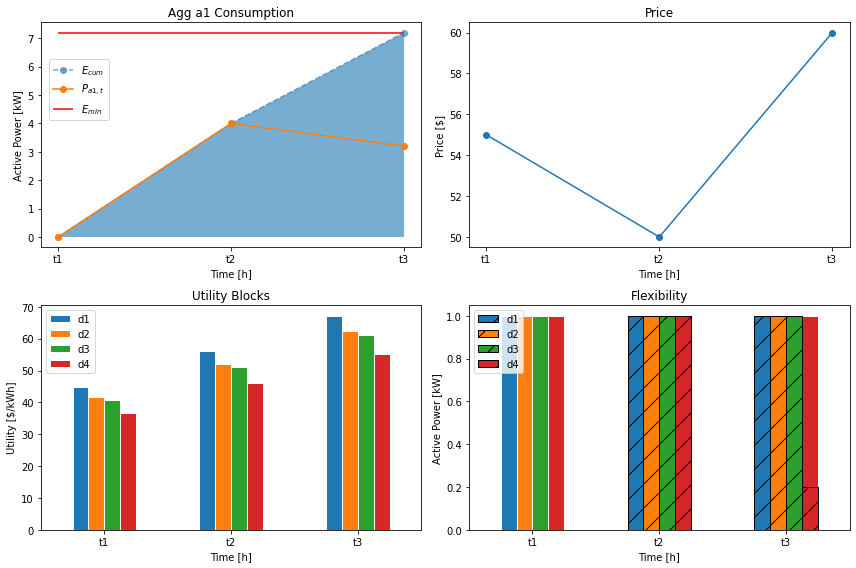

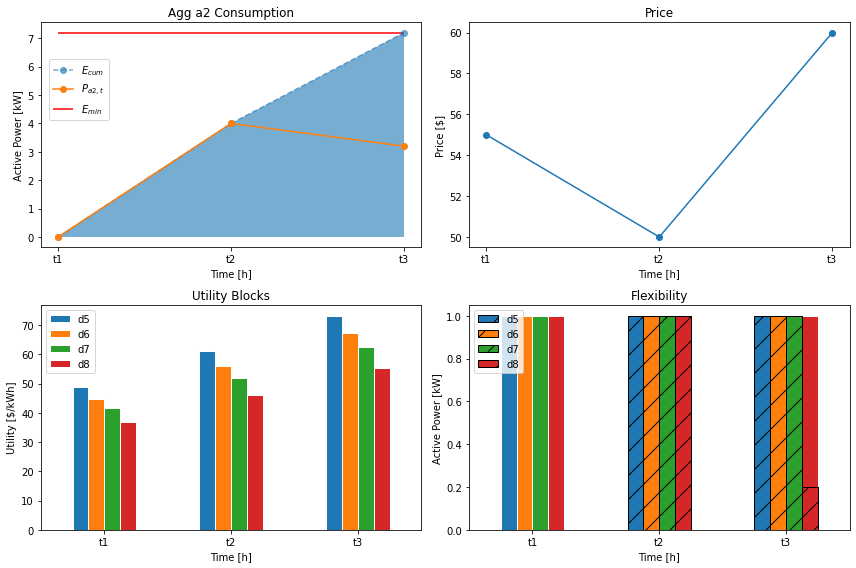

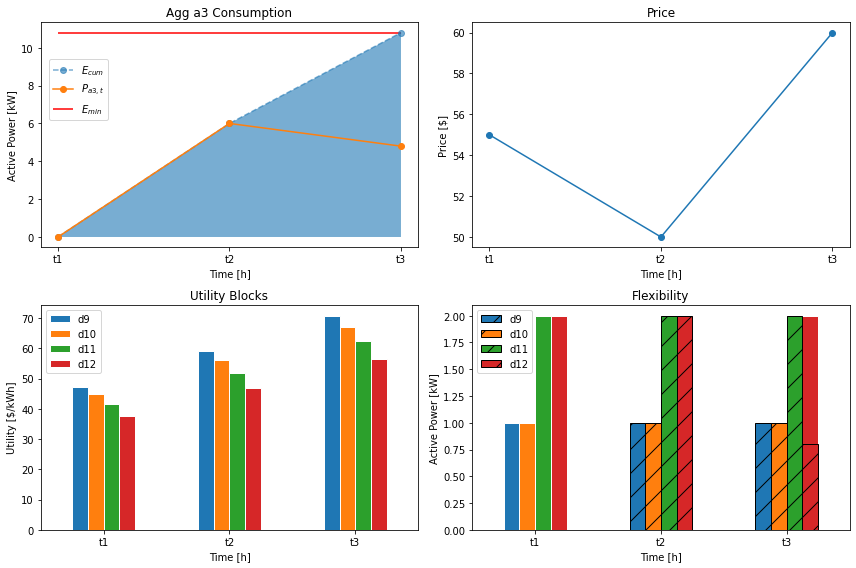

In [5]:
def follower_model(inputData, d_i):

    #---------------------------------------------------------------------------------------------------------
    #Inputs
    #---------------------------------------------------------------------------------------------------------
    NMd = 4     # number of demand blocks of DR aggregator
    AggData = inputData['AggData']
    DemandBlocks = inputData['DemandBlocks']
    TimeData = inputData['TimeData']

    aggs = [AggData.loc[i, 'AGG'] for i in AggData.index]
    dblocks = [DemandBlocks.loc[i, 'DB'] for i in DemandBlocks.index]
    time = [TimeData.loc[i, 'TIME'] for i in TimeData.index]
    utils = {(aggs[a], dblocks[d + NMd*a], time[t]) for a in AggData.index for d in range(NMd) for t in TimeData.index}  # $/MW

    RU = {aggs[i]:AggData.loc[i, 'RU'] for i in AggData.index}  # ramp up rate MW/h
    RD = {aggs[i]:AggData.loc[i, 'RD'] for i in AggData.index}  # ramp down rate MW/h

    MargUtil = {(aggs[a], dblocks[d + NMd*a], time[t]):TimeData.loc[t,'UtilMultiplier']*DemandBlocks.loc[DemandBlocks['AGG'] == \
                AggData.loc[a, 'AGG']]['MargUtil'].iloc[d] for a in AggData.index for d in range(NMd) for t in TimeData.index}  # $/MW

    # print([DemandBlocks.loc[DemandBlocks['AGG'] == AggData.loc[k, 'AGG']]['MargUtil'].iloc[i] for k in AggData.index for i in range(4)])
    # for key, value in MargUtil.items():
    #     print(key, ':', value)

    Load = {(aggs[a], dblocks[d + NMd*a], time[t]):DemandBlocks.loc[DemandBlocks['AGG'] == \
            AggData.loc[a, 'AGG']]['Load'].iloc[d] for a in AggData.index for d in range(NMd) for t in TimeData.index}      # MW

    Energy = {aggs[a]:sum(DemandBlocks.loc[i, 'Load'] for i in DemandBlocks.index for t in TimeData.index if AggData.loc[a, 'AGG'] \
                          == DemandBlocks.loc[i, 'AGG']) for a in AggData.index}

    Price = {time[t]:TimeData.loc[t, 'Price'] for t in TimeData.index}  # $
    #---------------------------------------------------------------------------------------------------------
    #Define the Model
    #---------------------------------------------------------------------------------------------------------

    fmodel = ConcreteModel()

    #---------------------------------------------------------------------------------------------------------
    #Define Sets
    #---------------------------------------------------------------------------------------------------------

    fmodel.AGG = Set(initialize=aggs)
    fmodel.BLOCK = Set(initialize=dblocks)
    fmodel.TIME = Set(initialize=time, ordered=True)
    fmodel.UTILS = Set(initialize=utils)

    #---------------------------------------------------------------------------------------------------------
    #Define Parameters
    #---------------------------------------------------------------------------------------------------------

    fmodel.ct = Param(fmodel.TIME, initialize=Price, mutable=True, within=NonNegativeReals)
    fmodel.RD = Param(fmodel.AGG, initialize=RD, mutable=True, within=NonPositiveReals)
    fmodel.RU = Param(fmodel.AGG, initialize=RU, mutable=True, within=NonNegativeReals)
    fmodel.util = Param(fmodel.UTILS, mutable=True, initialize=MargUtil, within=NonNegativeReals)
    fmodel.PblockMax = Param(fmodel.UTILS, mutable=True, initialize=Load, within=NonNegativeReals)

    fmodel.Etot = Param(fmodel.AGG, initialize=Energy, mutable=True, within=NonNegativeReals)
    def inflexible_energy(fmodel, a):
        return fmodel.Etot[a]*0.6
    fmodel.Einflex = Param(fmodel.AGG, rule=inflexible_energy)

    #---------------------------------------------------------------------------------------------------------
    #Define Variables
    #---------------------------------------------------------------------------------------------------------

    fmodel.Pdt = Var(fmodel.AGG, fmodel.TIME, within=NonNegativeReals, initialize=0)
    fmodel.Pdmt = Var(fmodel.UTILS, within=NonNegativeReals, initialize=0)

    #---------------------------------------------------------------------------------------------------------
    #Define Objective
    #---------------------------------------------------------------------------------------------------------

    def follower_obj(fmodel):
        return sum(fmodel.ct[t]*fmodel.Pdt[d_i,t] for t in fmodel.TIME) - \
               sum(fmodel.util[d,m,t]*fmodel.Pdmt[d,m,t] for d,m,t in fmodel.UTILS if d == d_i)
    fmodel.fobj = Objective(rule=follower_obj)
    #---------------------------------------------------------------------------------------------------------
    #Define Constraints
    #---------------------------------------------------------------------------------------------------------

    def aggregated_load_rule(fmodel, t_i):
        return fmodel.Pdt[d_i,t_i] == sum(fmodel.Pdmt[d,m,t] for d,m,t in fmodel.UTILS if d == d_i and t == t_i)
    fmodel.aggregated_load = Constraint(fmodel.TIME, rule=aggregated_load_rule)

    def max_block_size_rule(fmodel, d, m, t):
        if d == d_i:
            return inequality(0, fmodel.Pdmt[d,m,t], fmodel.PblockMax[d,m,t])
        else:
            return Constraint.Skip
    fmodel.max_block_size = Constraint(fmodel.UTILS, rule=max_block_size_rule)

    def total_energy_rule(fmodel):
        return sum(fmodel.Pdt[d_i,t] for t in fmodel.TIME) >= fmodel.Einflex[d_i]
    fmodel.total_energy = Constraint(rule=total_energy_rule)

    def agg_ramp_rule(fmodel, t):
        if fmodel.TIME.ord(t) == 1:
            # for testing purposes initialize initial consumption to 1 MW
            return inequality(fmodel.RD[d_i], fmodel.Pdt[d_i,t] - 1, fmodel.RU[d_i])
        elif fmodel.TIME.ord(t) > 1:
            return inequality(fmodel.RD[d_i], fmodel.Pdt[d_i,t] - fmodel.Pdt[d_i,fmodel.TIME.prev(t)], fmodel.RU[d_i])
    fmodel.agg_ramp = Constraint(fmodel.TIME, rule=agg_ramp_rule)

    return fmodel

results = dict.fromkeys(data['AggData']['AGG'].tolist())
solver = SolverFactory('gurobi')
# define and solve the problem for each aggregator
for agg in results:
    fmodel = follower_model(data, d_i=agg)
    #fmodel.pprint()
    result = solver.solve(fmodel)#, tee=True)
    results[agg] = result
    data_viz(fmodel, d_i=agg)